#Introduction

Since the first Babylonian law codes, to the birth of the printing press, and until today, writing information down has been an important facet of the human experience. In our society, we have the great advantage of reading for pleasure, knowledge, and work, with a vast amount of options. 

With this in mind, we will be looking at a dataset compiled by kaggle user Soumik and comparing the quality of books published by certain publishers. We would like to see if there are any significant differences in book quality between different publishers.

Although Soumik's dataset contains numerous unique publishers, we will be focusing on the largest three, as that will both streamline our research and provide a sufficient amount of data.

#Hypothesis

1. Null Hypothesis: There is no significant difference between the average ratings of books published by unique publishers.

2. Alternate Hypothesis: There is a significant difference between the average ratings of books published by unique publishers.

#Data

The data comes from [Kaggle](https://www.kaggle.com/jealousleopard/goodreadsbooks) and contains 10,352 unique book titles and 12 columns of information: bookID, title, authors, average rating, isbn, isbn13, language, number of pages, number of ratings, number of text reviews, publication date, and publisher. 

There are a few lines that are corrupted, so we will be ignoring those for this experiment. 

In [ ]:
# Here we set up the enviroment

%matplotlib inline
import math
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

PATH = 'https://raw.githubusercontent.com/NehemiahSolis/books_for_research_proposal/master/books.csv'
books = pd.read_csv(PATH, error_bad_lines = False)
books.info()
books.head()

# Count books by publisher

publishers = books.groupby('publisher').size().sort_values().reset_index(name='count').sort_values(['count'], ascending=False)
print(publishers)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7     num_pages         11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB
                 publisher  count
2289               Vintage    318
2288         Penguin Books    261
2287      Penguin Classics    184
2286   

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


             count
count  2290.000000
mean      4.857205
std      14.293135
min       1.000000
25%       1.000000
50%       1.000000
75%       3.000000
max     318.000000

Skewness: 10.776925
Kurtosis: 173.064159


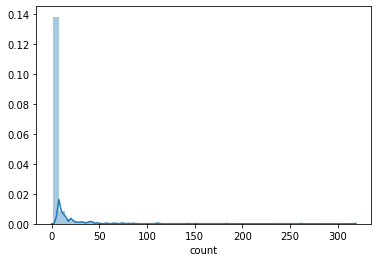

In [ ]:
# To further make sense of all these publishers, we can perform a univariate analysis

# First, we check the measures of central tendencies.

print(publishers.describe())
sns.distplot(publishers['count'])
print()
print('Skewness: %f' % publishers['count'].skew())
print('Kurtosis: %f' % publishers['count'].kurt())


Here, we see that the data is heavily skewed in favor of low count book publishers. We will need to clean this up in order for it to be usable. For one, the standard deviation is much too high (14.2) for the median only being 1. Publishers only publishing one to twenty books is also irrelevant for this experiment, so we can raise the minimum number of books published. I've settled on 40 books for the minimum since that gives us a good distribution set without cutting away too much of the data, with an acceptable kurtosis and skewness. It will also allow for ease of data visualization.


            count
count   45.000000
mean    80.377778
std     55.911573
min     41.000000
25%     48.000000
50%     65.000000
75%     85.000000
max    318.000000

Skewness: 2.762071
Kurtosis: 8.621089


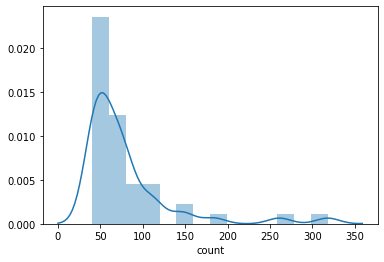

In [ ]:
new_publishers = publishers.loc[publishers['count'] > 40]
print(new_publishers.describe())

sns.distplot(new_publishers['count'])
print()
print('Skewness: %f' % new_publishers['count'].skew())
print('Kurtosis: %f' % new_publishers['count'].kurt())


In [ ]:
# The new set of publishers we can use for our experiment is ranked below.

print(new_publishers)


                         publisher  count
2289                       Vintage    318
2288                 Penguin Books    261
2287              Penguin Classics    184
2286                 Mariner Books    150
2285              Ballantine Books    144
2284              Harper Perennial    112
2283                 HarperCollins    112
2282                  Pocket Books    111
2281                        Bantam    110
2280                 VIZ Media LLC     88
2279                       Berkley     86
2278            Dover Publications     85
2277                Modern Library     82
2276                       Del Rey     80
2275                     Tor Books     76
2274      Grand Central Publishing     76
2273  Oxford University Press  USA     75
2272                      Scribner     73
2271       Oxford University Press     73
2270         W. W. Norton  Company     68
2269                        Signet     66
2268    Cambridge University Press     66
2267               Simon  Schuster

From here, our data has been cleaned up significantly. Many of these publishers listed are actually subsidiaries of a larger parent company. After doing some research, I found that the majority are Penguin Random House books, with a handful being books from Simon & Schuster and HarperCollins. The rest were from small publishing companies.

#Methods

For this analysis, I will be creating three DataFrames, one for each publishing parent company: Penguin Random House, Simon & Schuster, and HarperCollins. Many books have been published by subsidiaries of a parent company, so combining a few subsidiaries under one parent company will allow for a more stable and holistic result, reducing the amount of groups and increasing the sample size for each group. I researched the top publishers in the list, and determined the parent companies:

In the Penguin Random House (PRH) group, I will include: Vintage, Penguin Books, Penguin Classics, Ballantine Books, and Bantam

In the Simon & Schuster (SAS) group, I will include: Pocket Books, Scribner, Simon Schuster, and Simon & Schuster

In the HarperCollins (HC) group, I will include: Harper Perennial, HarperCollins, HaperCollins Publishers, HarperTorch, and Harper

In [ ]:
# Splitting up the dataset and adding a new parent company column

# Penguin Random House

PRH = books[books['publisher'].isin(['Vintage', 'Penguin Books', 'Penguin Classics', 'Ballantine Books', 'Bantam'])]
parent_company_PRH = []
for value in PRH['publisher']:
  if value == 'Vintage':
    parent_company_PRH.append('Penguin Random House')
  else:
    parent_company_PRH.append('Penguin Random House')

PRH['parent company'] = parent_company_PRH

# Simon & Schuster

SAS = books[books['publisher'].isin(['Pocket Books', 'Scribner', 'Simon Schuster', 'Simon & Schuster'])]
parent_company_SAS = []
for value in SAS['publisher']:
  if value == 'Pocket Books':
    parent_company_SAS.append('Simon & Schuster')
  else:
    parent_company_SAS.append('Simon & Schuster')

SAS['parent company'] = parent_company_SAS

# HarperCollins

HC = books[books['publisher'].isin(['Harper Perennial', 'HarperCollins', 'HarperCollins Publishers', 'HarperTorch', 'Harper'])]
parent_company_HC = []
for value in HC['publisher']:
  if value == 'Harper Perennial':
    parent_company_HC.append('HarperCollins')
  else:
    parent_company_HC.append('HarperCollins')

HC['parent company'] = parent_company_HC



print(PRH.info())
print(SAS.info())
print(HC.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017 entries, 21 to 11120
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              1017 non-null   int64  
 1   title               1017 non-null   object 
 2   authors             1017 non-null   object 
 3   average_rating      1017 non-null   float64
 4   isbn                1017 non-null   object 
 5   isbn13              1017 non-null   int64  
 6   language_code       1017 non-null   object 
 7     num_pages         1017 non-null   int64  
 8   ratings_count       1017 non-null   int64  
 9   text_reviews_count  1017 non-null   int64  
 10  publication_date    1017 non-null   object 
 11  publisher           1017 non-null   object 
 12  parent company      1017 non-null   object 
dtypes: float64(1), int64(5), object(7)
memory usage: 111.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 232 entries, 101 to 11097
Data column

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

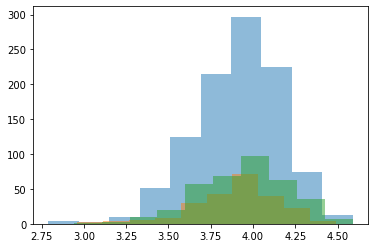

DescribeResult(nobs=1017, minmax=(2.79, 4.59), mean=3.9067944936086527, variance=0.06435565949720887, skewness=-0.5347657169044121, kurtosis=0.7850177893855728)
DescribeResult(nobs=232, minmax=(2.96, 4.49), mean=3.899439655172414, variance=0.06308929504403642, skewness=-0.681042381951772, kurtosis=1.0573731254532417)
DescribeResult(nobs=360, minmax=(2.94, 4.59), mean=3.9454722222222225, variance=0.06962094630145466, skewness=-0.4243547960161067, kurtosis=0.1262433523359503)


In [ ]:
# Now we will plot the histogram to visualize the data and determine normality of the average ratings

plt.hist(PRH['average_rating'], alpha = .5)
plt.hist(SAS['average_rating'], alpha = .5)
plt.hist(HC['average_rating'], alpha = .5)
plt.show()

print(stats.describe(PRH['average_rating']))
print(stats.describe(SAS['average_rating']))
print(stats.describe(HC['average_rating']))

Based on visual inspection and the skewness and kurtosis for each data set, it appears that our data is normally distributed.

Thus, we will perform a one-way ANOVA test to check for any significant differences in publisher quality.

If there is a statitistically significant difference between the three groups, I will also conduct an independent samples t-test between the groups at the two-tail, 95% confidence interval and a Tukey's Honest Significant Differences Test.

In [ ]:
# one-way ANOVA test

stats.f_oneway(PRH['average_rating'], SAS['average_rating'], HC['average_rating'])

F_onewayResult(statistic=3.506668665171931, pvalue=0.030226563863020174)

With a p-value < .5, one of these publishers stands out from the rest. Let's find out which publishing company that is.

In [ ]:
# Set of pairwise t-tests comparing each group

print(stats.ttest_ind(PRH['average_rating'], SAS['average_rating']))
print(stats.ttest_ind(PRH['average_rating'], HC['average_rating']))
print(stats.ttest_ind(SAS['average_rating'], HC['average_rating']))

Ttest_indResult(statistic=0.39920502411694386, pvalue=0.6898104972374366)
Ttest_indResult(statistic=-2.4599294596750703, pvalue=0.014018739790743225)
Ttest_indResult(statistic=-2.1113295540172823, pvalue=0.03516392944184399)


In [ ]:
# Confidence interval

def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return("The difference in means at the 95% confidence interval (two-tail) is between "+str(ci_lower)+" and "+str(ci_upper)+".")

print(get_95_ci(PRH['average_rating'], SAS['average_rating']))
print(get_95_ci(PRH['average_rating'], HC['average_rating']))
print(get_95_ci(SAS['average_rating'], HC['average_rating']))


The difference in means at the 95% confidence interval (two-tail) is between -0.04324031982598684 and 0.028530642953517794.
The difference in means at the 95% confidence interval (two-tail) is between 0.007276631148580487 and 0.07007882607856172.
The difference in means at the 95% confidence interval (two-tail) is between 0.0037524942038955414 and 0.08831263989571572.


In [ ]:
# Tukey's HSD Test

from statsmodels.stats.multicomp import pairwise_tukeyhsd

frames = [PRH, SAS, HC]
compilation_of_publishers = pd.concat(frames)

tukey = pairwise_tukeyhsd(endog = compilation_of_publishers['average_rating'],
                          groups = compilation_of_publishers['parent company'],
                          alpha=0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
HarperCollins,Penguin Random House,-0.0387,0.0366,-0.0755,-0.0019,True
HarperCollins,Simon & Schuster,-0.046,0.0826,-0.0965,0.0045,False
Penguin Random House,Simon & Schuster,-0.0074,0.9,-0.051,0.0363,False


#Results

Starting with our visual inspection, the average ratings of each publisher were close enough to a normal distribution that we could proceed with a one-way ANOVA test. Based on the p-value of .03 we can reject the NULL hypothesis that there is no significant difference in average ratings between publishers, since the p-value < .05. Subsequently, we performed another set of pairwise t-tests comparing each group, where we discovered that only HarperCollins publishing differed from the other two publishing parent companies. 

The 95% confidence interval suggests the following:


*   The difference in the average ratings between Penguin Random House and Simon & Schuster is between .04 worse and .07 better.
*   On average, Penguin Random House has a lower average book rating than HarperCollins ranging between .007 and .07.
*   On average, Simon & Schuster also has a lower average rating than HarperCollins, between .003 and .088.

Next, we come to the results of the Tukey's HSD test. With confidence, we can reject the null for HarperCollins and Penguin Random House. There is no significant difference between Simon & Schuster and the other publishers.






#Discussion and Recommendation

Based on our results, and specifically the Tukey's HSD test result, we determined that HarperCollins performed, on average, slightly better than Penguin Random House when it came to book quality. For any given book, a Penguin Random House book could have a lower rating than a HarperCollins publication, ranging between .007 and .07. 

While it appeared that Simon & Schuster performed worse than HarperCollins as well, the differences were not significant enough to reject the NULL. There is also no difference in quality between Penguin Random House and Simon & Schuster books.

For a customer looking to buy a book, there is an advantage to shopping with both HarperCollins and Penguin Random House. If you are looking for the guaranteed quality, HarperCollins will be better on average. Howver, as we saw with the data, there are a vast amounts of options to choose from with Penguin Random House publishing. They publish significantly more books than HarperCollins. Simon & Schuster books, as their quality of books ranks similarily to the other publishers, is a safe, if uneventful choice.

Similarily, writers would have to weigh their options when courting a publisher. On the one hand, it would be advantageous to favor HarperCollins, as their knack for quality is a draw for any aspiring author.

**On what could improve the experiment:**

Several subsidiaries of each parent were excluded, so another test could be conducted that was more inclusive of the publisher data. This may have an impact on the results, and would be fairly easy to test for. If I were to collect new data in this domain, I would try to create a new column that contains the publisher's parent company. In this way, I wouldn't have to arbitrarily assign values to new groups and potentially miss any subsidiaries. 

#For the powerpoint

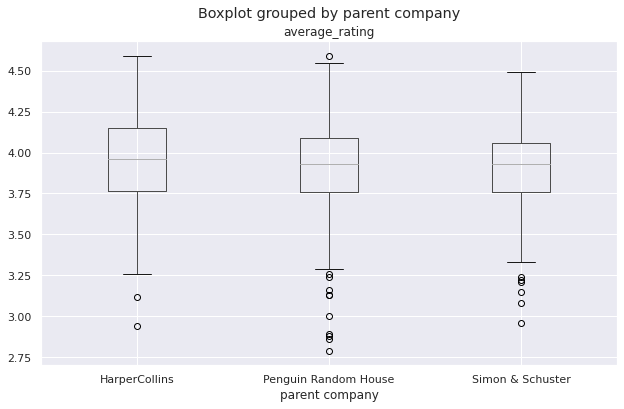

In [ ]:
compilation_of_publishers.boxplot('average_rating', by='parent company', figsize=(10, 6))

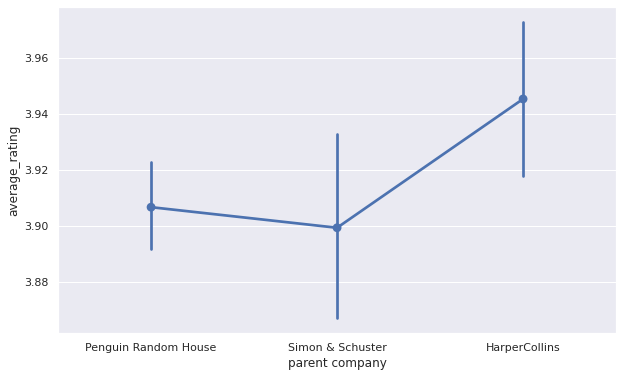

In [ ]:
sns.set(style="darkgrid")
fig_dims = (10,6)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.pointplot(x="parent company", y="average_rating", ax=ax, data=compilation_of_publishers)